/var/folders/zg/w5pp8km560dfjlrqkfg6yrg00000gn/T/ipykernel_14490/1554008289.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(model_names))


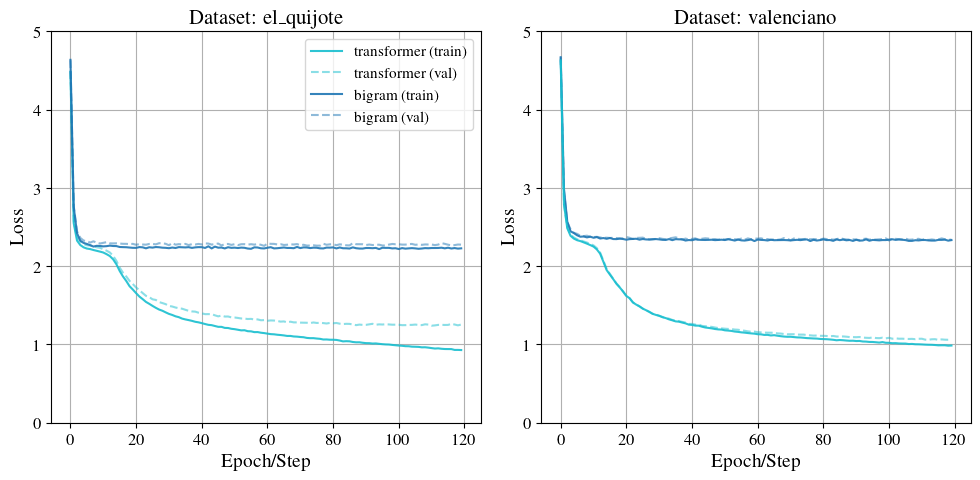

In [ ]:
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import re

# --------- NEURIPS/ICLR STYLE ------------
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
    "axes.labelsize": 14,
    "font.size": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.titlesize": 15,
    "axes.labelweight": "bold",
})
# ------------------------------------------

def latex_escape(text):
    """
    Escapa caracteres especiales para LaTeX en los labels
    """
    conv = {
        '&':  r'\&',
        '%':  r'\%',
        '$':  r'\$',
        '#':  r'\#',
        '_':  r'\_',
        '{':  r'\{',
        '}':  r'\}',
        '~':  r'\textasciitilde{}',
        '^':  r'\textasciicircum{}',
        '\\': r'\textbackslash{}',
    }
    regex = re.compile('|'.join(re.escape(key) for key in conv.keys()))
    return regex.sub(lambda match: conv[match.group()], text)

CHECKPOINTS_DIR = "checkpoints"
data_by_dataset = defaultdict(lambda: defaultdict(list))  # dataset -> model -> list of (train, val)

for filename in os.listdir(CHECKPOINTS_DIR):
    if filename.endswith('.json'):
        path = os.path.join(CHECKPOINTS_DIR, filename)
        with open(path, "r") as f:
            obj = json.load(f)
            dataset = obj["dataset"]
            model = obj["model"]
            train = obj["train"]
            val = obj["val"]
            data_by_dataset[dataset][model].append((train, val))

datasets = sorted(data_by_dataset.keys())
num_datasets = len(datasets)

model_names = set()
for models in data_by_dataset.values():
    model_names.update(models.keys())
model_names = sorted(model_names)
colors = plt.cm.get_cmap("tab10", len(model_names))
model2color = {model: colors(i) for i, model in enumerate(model_names)}

fig, axs = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5), sharex=True)
if num_datasets == 1:
    axs = [axs]

for i, dataset in enumerate(datasets):
    ax = axs[i]
    ax.set_title(r"Dataset: " + latex_escape(f"{dataset}"), fontsize=15)
    ax.set_ylabel(r"Loss", fontsize=14)
    ax.set_xlabel(r"Epoch/Step", fontsize=14)
    ax.set_ylim(0, 5)

    for model, runs in data_by_dataset[dataset].items():
        color = model2color[model]
        for idx, (train, val) in enumerate(runs):
            label_train = latex_escape(f"{model} (train) #{idx+1}" if len(runs) > 1 else f"{model} (train)")
            label_val = latex_escape(f"{model} (val) #{idx+1}" if len(runs) > 1 else f"{model} (val)")
            ax.plot(train, label=label_train, color=color, linestyle="-", alpha=0.9)
            ax.plot(val, label=label_val, color=color, linestyle="--", alpha=0.5)
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.savefig("reports/loss_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()